# **CS 181 HW6 Problem 2 - Policy and Value Iteration**
---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

## Util methods to represent the grid (do not modify)
#### You do not need modify any of these methods to complete Problem 2

In [3]:
# Maze state is represented as a 2-element NumPy array: (Y, X). Increasing Y is South.
grid = [
    'o.x.u',
    '..y..',
    '..y.*',
    '..z..']
topology = np.array([list(row) for row in grid])
flat_topology = topology.ravel()
rewards = {'.': 0, '*': 50, 'o': 4, 'u': 20, 'x': -10, 'y': -50,'z': -20}

row_count = len(grid) # 4
col_count = len(grid[0]) # 5
shape = (row_count, col_count) # (4, 5)

# Possible actions, expressed as (delta-y, delta-x)
directions="NSEW"
maze_actions = {
    'N': np.array([-1, 0]),
    'S': np.array([1, 0]),
    'E': np.array([0, 1]),
    'W': np.array([0, -1]),
}
actions = [maze_actions[direction] for direction in directions]


# Returns true if pos (y,x) is out of bounds
def is_wall(pos):
    (y, x) = pos
    return (y < 0 or y >= row_count or x < 0 or x >= col_count)

# Input is a flattened state, returns the reward at that state
def get_reward(state):
    assert (state in range(num_states)), f"get_reward: State was not an integer representing an in-bounds state ({state} was given)"
    return rewards.get(flat_topology[int(state)])

# Input is a flattened state, returns the unflattened representation of the state
def unflatten_index(flattened_index):
    return np.unravel_index(flattened_index, shape)

# Input state is an unflattened position and action is an index into the actions[] array
# Returns a tuple containing the new position of taking the action from the state
def move(state, action):
    return tuple((state + actions[action]).reshape(1, -1)[0])

# Returns an array of the "side states" when taking action beginning at unflattened position state
# Does not return states which are out of bounds
def get_side_states(action, state):
    side_states = []
    
    if action == 0 or action == 1:
        if not is_wall(move(state, 3)):
            side_states.append(move(state, 3))
        if not is_wall(move(state, 2)):
            side_states.append(move(state, 2))
    elif action == 2 or action == 3:
        if not is_wall(move(state, 0)):
            side_states.append(move(state, 0))
        if not is_wall(move(state, 1)):
            side_states.append(move(state, 1))
            
    return side_states
    
# Inputs s1, s2 are flattened states, action represents an index into the actions array
# Returns p(s2 | s1, action)
def get_transition_prob(s1, action, s2):
    # Check the inputs are valid
    assert (action in [0,1,2,3]), f"get_transition_prob: Action needs to be an integer in [0,1,2,3], but {action} was given"
    assert (s1 in range(num_states)), f"get_transition_prob: Input s1 was not an integer representing an in-bounds state ({s1} was given)"
    assert (s2 in range(num_states)), f"get_transition_prob: Input s2 was not an integer representing an in-bounds state ({s2} was given)"
    
    state1 = unflatten_index(int(s1))
    state2 = unflatten_index(int(s2))
    action = int(action)

    new_state = move(state1, action)

    sstates = get_side_states(action, state1)
    succeed_prb = 0.8
    slip_prb = 0.1

    # One of the side states was a wall: adjust probabilities accordingly.
    if len(sstates) == 1:
        succeed_prb = 0.9

    if is_wall(new_state):
        if(state1 == state2):
            return succeed_prb
    else:
        if(state2 == new_state):
            return succeed_prb

    # Oherwise, check if state2 is on either side
    for side_state in sstates:
        if(state2 == side_state):
            return slip_prb

    return 0.

In [49]:
# MAKE PLOTS (do not modify)

# Util to draw the value function V as numbers on a plot.
def make_value_plot(V):
    # Useful stats for the plot
    value_function = np.reshape(V, shape)

    # Write the value on top of each square
    indx, indy = np.arange(row_count), np.arange(col_count)

    fig, ax = plt.subplots()
    ax.imshow(value_function, interpolation='none', cmap= plt.get_cmap('coolwarm_r'))

    for s in range(len(V)):
        val = V[s]
        (xval, yval) = unflatten_index(s)
        t = "%.2f"%(val,) # format value with 1 decimal point
        ax.text(yval, xval, t, color='black', va='center', ha='center', size=15)
        

# Util to draw the policy pi as arrows on a plot.
def make_policy_plot(pi, iter_type, iter_num):
    # Useful stats for the plot
    row_count = len(grid)
    col_count = len(grid[0])
    policy_function = np.reshape(pi, shape)

    for row in range(row_count):
        for col in range(col_count):
            if policy_function[row,col] == 0:
                dx = 0; dy = -.5
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = .5; dy = 0
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            plt.arrow( col , row , dx , dy , shape='full', fc='w' , ec='gray' , lw=1., length_includes_head=True, head_width=.1 )
    plt.title(iter_type + ' Iteration, i = ' + str(iter_num))
    plt.savefig(iter_type + '_' + str(iter_num) + '.png')
    plt.show()

## Please read the rest of this file before beginning to code

In [5]:
np.random.seed(181)
VALUE_ITER = 'Value'
POLICY_ITER = 'Policy'

num_states = shape[0] * shape[1] # num_states = 20
num_actions = len(actions) # num_actions = 4

# TO-DOS FOR PROBLEM 2
Below you will implement policy and value iteration.

A state is represented as an integer from ``0`` to ``num_states - 1``
<br>
An action is represented as an integer in ``[0,1,2,3]``, which represents the four cardinal directions [N,S,E,W]

Each state has a reward associated with it. The agent gains the reward of a state when it takes an action at that state, not immediately upon entry.

``pi`` contains the learned policy at each state, represented by an array of length ``num_states``. In this exercise we will be implementing a deterministic policy, so each state has exactly one action associated with it.
<br>
ex: [2, 3, 1, 1, 2, 0, 1, 2, 2, 1, 3, 0, 0, 2, 2, 1, 3, 3, 2, 0]

``V`` represents the learned value function at each state. Like the above, it is also represented as an array of length ``num_states`` where the entry at index ``i`` represents the value of state ``i``.


## Helper methods

Recall that when you take an action in Gridworld, you won't always necessarily move in that direction. Instead there is some probability of moving to a state on either side. You do not need to calculate these transition probabilities yourself. Please use the helper functions ``get_transition_prob`` and ``get_reward`` in this file. The method headers are listed below:

``get_reward(state):`` Input is a state, output is the reward at that state

``get_transition_prob(s1, a, s2):`` Returns the probability of transitioning from state ``s1`` to state ``s2`` upon taking action ``a``.

An example is given below:

In [18]:
# Example usage
print(get_reward(14))
print(get_transition_prob(16, 0, 17))
print(get_transition_prob(16, 1, 17))
print(get_transition_prob(16, 2, 17))
print(get_transition_prob(16, 3, 17))
print(get_transition_prob(13, 1, 13))

50
0.1
0.1
0.9
0.0
0.0


## 1a) Policy Evaluation

Returns array ``V`` representing the value of policy ``pi`` using discount factor ``gamma``

Note: You can do this either closed-form or iteratively. If performed iteratively, please use a convergence tolerance of at least ``0.0001``

In [7]:
# TODO: Complete this function
def policy_evaluation(pi, gamma):
    theta = 0.0001   # not needed... for finite time horizon MDP for large T
    
    # implement closed-form linear sys of eq for infinite time horizon MDP
    # V = (I - gamma*t)^-1 @ r.T  for reward vec r and next-state transition matrix t
    
    # make reward vector len of num_states, where elem i corresponds to reward of state i
    r = np.zeros(num_states)
    for i in range(0,num_states):
        r[i] = get_reward(i)

    
    # make transition matrix t
    t = np.zeros((num_states,num_states))
    for i in range(0, num_states):
        for j in range(0, num_states):
            # total transition prob from current state i to next state j by action pi[i] (deterministic policy)
            t[i][j] = get_transition_prob(i, pi[i], j)
    
    # closed-form V
    V = np.linalg.inv(np.identity(num_states) - gamma*t) @ r.T
    
    return V

In [8]:
r = np.array([5,0,-0.5,0,0,-0.5,0,0,-0.5])
t = np.array([[0.5,0,0,0,0,0,0,0.5,0],
             [0,0.5,0.5,0,0,0,0,0,0],
             [0,0,1,0,0,0,0,0,0],
             [0,0,0,0.5,0.5,0,0,0,0],
             [0,0,0,0,0.5,0.5,0,0,0],
             [0,0,0,0,0,1,0,0,0],
             [0,0,0,0,0,0,0.5,0.5,0],
             [0,0,0,0,0,0,0,0.5,0.5],
             [0,0,0,0,0,0,0,0,1],
             ])
print(np.linalg.inv(np.identity(9) - 0.9*t)@r.T)

[ 5.74380165 -4.09090909 -5.         -3.34710744 -4.09090909 -5.
 -3.34710744 -4.09090909 -5.        ]


In [9]:
print(policy_evaluation(np.zeros(num_states), 0.9))
V = policy_evaluation(np.zeros(num_states), 0.9)
policy_evaluation(np.zeros(num_states), 0.9).shape

[ 20.00798691  -2.20536098 -26.86910995  29.72368559 119.34279844
  15.641626    -6.27603767 -67.73249008  24.20124964  98.8457792
  11.56262917 -12.30097657 -98.03184522  20.47372817 131.90771669
   7.89891456 -16.29794525 -90.57938259  16.33734489 108.31561156]


(20,)

## 1b) Policy Iteration

Now that we have ``V`` computed in 1a), perform **one step** of policy iteration to return the updated policy ``pi_new``

In [19]:
# TODO: Complete this function
def update_policy_iteration(V, gamma):
    # note that reward doesn't depend on action: r(s,a) --> r(s)  
    # pi_new = argamax_a [r(s) + gamma * sum_s'{p(s'|s,a)*V(s')}] = argamax_a [gamma * sum_s'{p(s'|s,a)*V(s')}]
    pi_new = np.zeros(num_states)
    
    # for every current state
    for i in range(0, num_states):
        sum_arr = np.zeros(4) # array to compare sum for each action
       
        # for every action from current to next state
        for k in range(0, 4):
            # for every next state
            for j in range(0, num_states):
                # gamma * sum_s'{p(s'==j|s,a==k)*V(s==j)
                sum_arr[k] += gamma*get_transition_prob(i, k, j)*V[j]
        
        # whichever entry of sum_arr has max val corresponds to argmax_a
        pi_new[i] = np.argmax(sum_arr)   # if 1+ entry is max entry, then np picks earliest element of sum_arr
            
    
    return pi_new

In [20]:
x = np.array([5,0,10,10,5])
np.argmax(x)

2

In [21]:
update_policy_iteration(V, 0.9)

array([3., 3., 2., 2., 2., 0., 3., 2., 2., 1., 0., 3., 2., 2., 2., 0., 3.,
       2., 2., 0.])

## 2) Value Iteration
Given a value function ``V`` and a policy ``pi``, perform **one step** of value iteration and return the updated ``V_new``, ``pi_new``

In [43]:
# TODO: Complete this function
def update_value_iteration(V, pi, gamma):
    # V_new = max_a [r(s) + gamma * sum_s'{p(s'|s,a)*V(s')}]
    V_new = np.zeros(num_states)
    
    # for every current state
    for i in range(0, num_states):
        sum_arr = np.zeros(4) # array to compare sum for each action
       
        # for every action from current to next state
        for k in range(0, 4):
            sum_arr[k] = get_reward(i)
            # for every next state
            for j in range(0, num_states):
                # gamma * sum_s'{p(s'==j|s,a==k)*V(s==j)
                sum_arr[k] += gamma*get_transition_prob(i, k, j)*V[j]
        
        # whichever entry of sum_arr has max val corresponds to max_a
        V_new[i] = np.max(sum_arr)   # if 1+ entry is max entry, then np picks earliest element of sum_arr
    
    
    
    # now that we know V_new, can find corresponding pi_new
    # pi_new = argamax_a [r(s) + gamma * sum_s'{p(s'|s,a)*V(s')}] = argamax_a [gamma * sum_s'{p(s'|s,a)*V(s')}]
    pi_new = np.zeros(num_states)
    
    # for every current state
    for i in range(0, num_states):
        sum_arr = np.zeros(4) # array to compare sum for each action
       
        # for every action from current to next state
        for k in range(0, 4):
            # for every next state
            for j in range(0, num_states):
                # gamma * sum_s'{p(s'==j|s,a==k)*V(s==j)
                sum_arr[k] += gamma*get_transition_prob(i, k, j)*V[j]
        
        # whichever entry of sum_arr has max val corresponds to argmax_a
        pi_new[i] = np.argmax(sum_arr)   # if 1+ entry is max entry, then np picks earliest element of sum_arr


    return V_new, pi_new

# Run code, plot results

The ``learn_strategy`` method iteratively runs the one-step methods you wrote in parts 1 and 2, either until the value function converges under <TT>ct</TT> or until a specified number of iterations <TT>max_iter</TT> have elapsed. It will also print out intermediate plots of the learned policy and value function at intervals of <TT>print_every</TT>. The arguments of the function are listed in more detail below:

``planning_type`` (<TT>string</TT>): 
    Specifies whether value or policy iteration is used to learn the strategy.
    
``max_iter`` (<TT>int</TT>):
    The maximum number of iterations (i.e. number of updates) the learning
    policy will be run for.
    
``print_every`` (<TT>int</TT>):
    The frequency at which the function will print value and policy plots.
    
``ct`` (<TT>float</TT>):
    The convergence tolerance used for policy or value iteration.
    
``gamma`` (<TT>float</TT>):
    The discount factor.

In [44]:
# Do not modify the learn_strategy method, but read through its code
def learn_strategy(planning_type = VALUE_ITER, max_iter = 10, print_every = 5, ct = None, gamma = 0.7):
    # Loop over some number of episodes
    V = np.zeros(num_states)
    pi = np.zeros(num_states)

    # Update Q-table using value/policy iteration until max iterations or until ct reached
    for n_iter in range(max_iter):
        V_prev = V.copy()

        # Update V and pi using value or policy iteration.
        if planning_type == VALUE_ITER:
            V, pi = update_value_iteration(V, pi, gamma)
        elif planning_type == POLICY_ITER:
            V = policy_evaluation(pi, gamma)
            pi = update_policy_iteration(V, gamma)
        
        # Calculate the difference between this V and the previous V
        diff = np.absolute(np.subtract(V, V_prev))

        # Check that every state's difference is less than the convergence tol
        if ct and np.max(diff) < ct:
            print(np.max(diff))
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)
            print("Converged at iteration " + str(n_iter+1))
            return 0

        # Make value plot and plot the policy
        if (n_iter % print_every == 0):
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)

## Show Policy Iteration

Beginning policy iteration.
[10.45759958  1.86697366 22.19286257  5.22612324 55.04278007  6.23839116
  4.99852245 62.71006545  0.96905943 34.74478561  3.33040062  8.5683687
 85.74748819  0.42951045 71.8591492   1.43208367  9.51526748 68.81752664
  1.89806476 45.13839946]


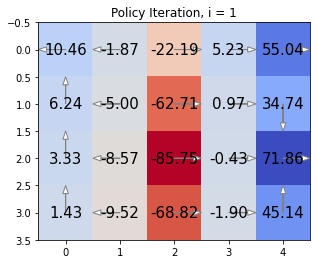

[ 1.89716489 10.02787159 42.63959169 44.57168311 17.00033731  1.92250677
 10.38989832 49.4830815  62.04011765 60.34026343  2.06097525 12.13994262
 86.55614321 90.0824129  72.0684804   2.13949025 12.01536922 90.65921984
 68.22360023 50.17879466]
[1.55259178e+00 8.20655657e+00 4.79377464e+00 7.53678832e+00
 1.19014721e+01 1.06667364e+00 1.26486880e+00 6.51400034e-01
 5.55155437e-01 4.37888741e-02 7.65076999e-01 1.32960865e+00
 7.06966275e-02 4.36926410e-02 7.82221195e-03 1.29462322e+00
 1.16089245e+01 9.01065962e-03 6.44745349e-03 5.37931527e-03]


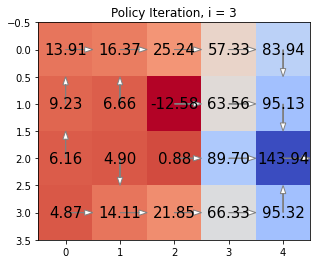

[1.22341483 0.17056022 0.         0.         0.         0.94131156
 2.43657451 0.         0.         0.         0.85181101 3.69692464
 0.         0.         0.         4.67610222 0.25878472 0.
 0.         0.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


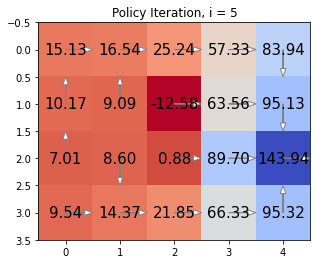

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


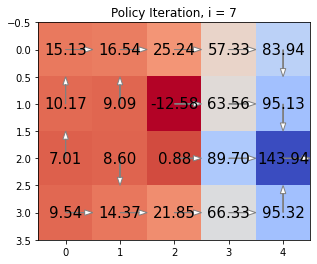

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


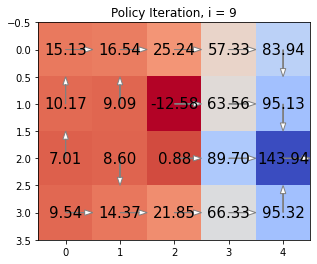

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Policy iteration complete.



In [40]:
print('Beginning policy iteration.')
learn_strategy(planning_type=POLICY_ITER, max_iter = 10, print_every = 10, ct = None, gamma = 0.7)
print('Policy iteration complete.\n')

## Show Value Iteration

Beginning value iteration.


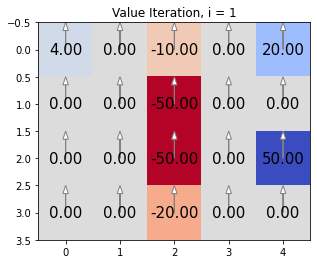

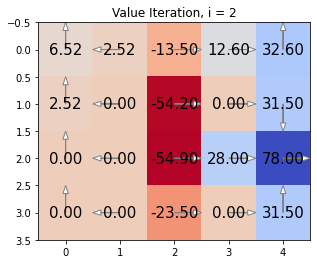

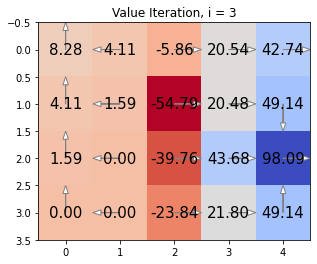

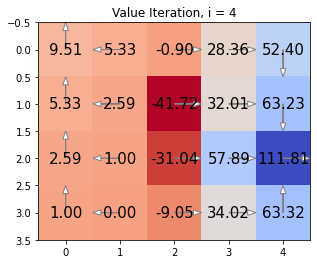

Value iteration complete.



In [50]:
print('Beginning value iteration.')
learn_strategy(planning_type=VALUE_ITER, max_iter = 4, print_every = 1, ct = 0.01, gamma = 0.7)
print('Value iteration complete.\n')